## Fama-French Regression - Equal Weighted
### Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm
import statistics
import sys
sys.path.insert(0, "../")
import util
from importlib import reload
util=reload(util)

### Set Local Macro Variables

In [2]:
# Number of stocks in Portfolio
nstocks = 20

#Set a start date
StartDate='12/31/1990'

### Import Data
#### Beta Rankings

In [3]:
data = pd.read_csv('qFFdata_better_beta.csv.gz', compression='gzip', usecols=lambda x: x.lower())

data['jdate'] = pd.to_datetime(data['jdate'])

data.head()

,permno,permco,ret,retx,shrout,prc,shrcd,exchcd,namedt,nameendt,...,mktSD,covmktstock,win_beta,normal_beta,beta_delta,better_beta_flag,lagbeta_delta,me,ranklagbeta_delta,lagbeta_deltaq
0,85477,15743,-0.010870,-0.010870,12959.0,12.74,11.0,3.0,2004-06-10,2009-07-09,...,0.011542,0.000035,0.262594,0.024717,-0.237878,0,51.462616,165097.66,2373.0,4
1,90400,45708,0.045201,0.045201,10028.0,16.88,11.0,3.0,2012-05-02,2013-06-30,...,0.008042,0.000084,1.305096,1.522156,0.217060,1,36.839385,169272.64,2673.0,4
2,88368,37737,0.001592,0.001592,16677.0,6.29,11.0,3.0,2006-07-07,2021-09-30,...,0.008518,0.000063,0.869271,0.872824,0.003552,1,34.275740,104898.33,2672.0,4
3,92456,52874,0.028807,0.028807,70683.0,2.50,11.0,3.0,2008-06-23,2021-09-30,...,0.006973,0.000052,1.070131,0.621556,-0.448574,0,32.388784,176707.50,2780.0,4
4,86512,16340,0.007792,0.007792,17605.0,7.76,11.0,3.0,1999-07-01,2004-06-09,...,0.017773,0.000153,0.483456,0.478097,-0.005359,0,22.043021,136614.80,2716.0,4


In [4]:
data.permno.nunique()

4897

In [48]:
data.annRet.describe()

count    11597.000000
mean         0.359148
std          1.294731
min         -0.980446
25%         -0.231371
50%          0.115472
75%          0.576227
max         37.703760
Name: annRet, dtype: float64

#### Annual Returns Data (includes Jan Effect)

In [5]:
data2 = pd.read_csv('AnnRet.csv.gz', compression='gzip', usecols=lambda x: x.lower())

data2['jdate'] = pd.to_datetime(data2['jdate'])

data2['jdate'] = data2['jdate']+MonthEnd(0)

data2 = data2.drop(columns=['permco','shrcd','exchcd','ret','retx','shrout','prc','dlret','dlstdt','retadj','retxadj','month','year','1+retadj','daycount', 'namedt', 'nameendt'])

data2.head()

,permno,jdate,annRet,annRet10
0,10001,1990-12-31,-0.009264,-0.009264
1,10001,1991-12-31,0.607307,0.650747
2,10001,1992-12-31,0.013423,0.013423
3,10001,1993-12-31,0.371066,0.323788
4,10001,1994-12-31,-0.090405,-0.064961


In [10]:
data3 = pd.merge(data,data2, how ='inner', on = ['permno','jdate'])

data3 = data3.drop(columns = ['annRet_x', 'annRet10_x'])

data3 = data3.rename(columns={'annRet_y': 'annRet'})
data3 = data3.rename(columns={'annRet10_y': 'annRet10'})

data3['volRank'] = data3.groupby(['year'])['lagbeta_delta'].rank(ascending=True)

data3.head()

,permno,permco,ret,retx,shrout,prc,shrcd,exchcd,namedt,nameendt,...,normal_beta,beta_delta,better_beta_flag,lagbeta_delta,me,ranklagbeta_delta,lagbeta_deltaq,annRet,annRet10,volRank
0,85477,15743,-0.010870,-0.010870,12959.0,12.74,11.0,3.0,2004-06-10,2009-07-09,...,0.024717,-0.237878,0,51.462616,165097.66,2373.0,4,0.606554,0.650255,261.0
1,90400,45708,0.045201,0.045201,10028.0,16.88,11.0,3.0,2012-05-02,2013-06-30,...,1.522156,0.217060,1,36.839385,169272.64,2673.0,4,-0.254416,-0.244066,561.0
2,88368,37737,0.001592,0.001592,16677.0,6.29,11.0,3.0,2006-07-07,2021-09-30,...,0.872824,0.003552,1,34.275740,104898.33,2672.0,4,0.929447,0.938368,560.0
3,92456,52874,0.028807,0.028807,70683.0,2.50,11.0,3.0,2008-06-23,2021-09-30,...,0.621556,-0.448574,0,32.388784,176707.50,2780.0,4,1.358511,1.083351,668.0
4,86512,16340,0.007792,0.007792,17605.0,7.76,11.0,3.0,1999-07-01,2004-06-09,...,0.478097,-0.005359,0,22.043021,136614.80,2716.0,4,0.119474,0.149238,604.0


## Create Portfolio Returns
### Equal Weighted Returns
#### Jan 1 start date

In [11]:
# For equal weighted returns from Jan 1 
returns3 = data3.copy()

# Select the N stocks with the lowest absolute value of beta for each month
returns3 = returns3[returns3['volRank']<=nstocks]

# Create equal weighted returns for each period
returns3['wret']=returns3['annRet']*(1/nstocks)
port3=returns3.groupby(['jdate'])['wret'].sum().reset_index(name='ewret')
port3['jdate'] = pd.to_datetime(port3['jdate'])

In [12]:
# For equal weighted returns from Jan 10 
returns4 = data3.copy()

# Select the N stocks with the lowest absolute value of beta for each month
returns4 = returns4[returns4['volRank']<=nstocks]

# Create value weighted returns for each period
returns4['wret']=returns4['annRet10']*(1/nstocks)
port4=returns4.groupby(['jdate'])['wret'].sum().reset_index(name='ewret10')
port4['jdate'] = pd.to_datetime(port4['jdate'])

In [13]:
port = pd.merge(port3,port4,on='jdate',how='inner')

port.head()

,jdate,ewret,ewret10
0,1991-12-31,0.580939,0.653523
1,1992-12-31,0.220341,0.155795
2,1993-12-31,0.178015,0.193901
3,1996-12-31,0.259740,0.289795
4,1997-12-31,0.290663,0.285364


### Export Sample Portfolio

In [14]:
port

,jdate,ewret,ewret10
0,1991-12-31,0.580939,0.653523
1,1992-12-31,0.220341,0.155795
2,1993-12-31,0.178015,0.193901
3,1996-12-31,0.259740,0.289795
4,1997-12-31,0.290663,0.285364
5,1998-12-31,0.184991,0.286333
6,1999-12-31,0.504749,0.409876
7,2001-12-31,0.080893,0.032688
8,2002-12-31,0.045332,0.034971
9,2003-12-31,0.621675,0.538276


In [47]:
port.ewret.describe()

count    22.000000
mean      0.195673
std       0.242569
min      -0.355572
25%       0.054222
50%       0.190144
75%       0.333436
max       0.621675
Name: ewret, dtype: float64

In [15]:
port.to_csv("ew_sample_port.csv.gz", 
           index=False, 
           compression="gzip")

## Fama-French Factors
### Import Data
#### Fama-French 5 Factors

In [16]:
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')

ff.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.01,-0.35,0.03,0.11,0.012
1,19630702,0.79,-0.31,0.24,-0.08,-0.25,0.012
2,19630703,0.63,-0.16,-0.09,0.13,-0.24,0.012
3,19630705,0.40,0.09,-0.26,0.07,-0.28,0.012
4,19630708,-0.63,0.07,-0.19,-0.27,0.06,0.012


In [17]:
ff.dtypes

Date        int64
Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
RF        float64
dtype: object

In [18]:
# Convert Date to an actual date format
ff['date'] = pd.to_datetime(ff['Date'].astype(str), format='%Y%m%d')

ff.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,date
0,19630701,-0.67,0.01,-0.35,0.03,0.11,0.012,1963-07-01
1,19630702,0.79,-0.31,0.24,-0.08,-0.25,0.012,1963-07-02
2,19630703,0.63,-0.16,-0.09,0.13,-0.24,0.012,1963-07-03
3,19630705,0.40,0.09,-0.26,0.07,-0.28,0.012,1963-07-05
4,19630708,-0.63,0.07,-0.19,-0.27,0.06,0.012,1963-07-08


In [19]:
# Drop extra variables
ff.drop(['Date'], axis = 1, inplace=True)

In [20]:
# Rename columns
ff.columns = ['MKTRF','SMB','HML','RMW','CMA','RF','date']

ff.head()

,MKTRF,SMB,HML,RMW,CMA,RF,date
0,-0.67,0.01,-0.35,0.03,0.11,0.012,1963-07-01
1,0.79,-0.31,0.24,-0.08,-0.25,0.012,1963-07-02
2,0.63,-0.16,-0.09,0.13,-0.24,0.012,1963-07-03
3,0.40,0.09,-0.26,0.07,-0.28,0.012,1963-07-05
4,-0.63,0.07,-0.19,-0.27,0.06,0.012,1963-07-08


In [21]:
ff['date'] = pd.to_datetime(ff['date'], format='%Y')
ff['date'] = ff['date']+YearEnd(0)
ff = ff.rename(columns={'date':'jdate'})

ff.head()

,MKTRF,SMB,HML,RMW,CMA,RF,jdate
0,-0.67,0.01,-0.35,0.03,0.11,0.012,1963-12-31
1,0.79,-0.31,0.24,-0.08,-0.25,0.012,1963-12-31
2,0.63,-0.16,-0.09,0.13,-0.24,0.012,1963-12-31
3,0.40,0.09,-0.26,0.07,-0.28,0.012,1963-12-31
4,-0.63,0.07,-0.19,-0.27,0.06,0.012,1963-12-31


## Combine Datasets

In [31]:
returnReg = pd.merge(port,ff,how='left',on=['jdate'])

In [32]:
returnReg = returnReg[~(returnReg['jdate']<StartDate)]

In [40]:
# Normalize start date to 0 and convert Ken French data from percent back to number
returnReg['MKTRF']=np.where(returnReg['jdate']==StartDate,0, returnReg['MKTRF']/100)
returnReg['SMB']=np.where(returnReg['jdate']==StartDate,0, returnReg['SMB']/100)
returnReg['HML']=np.where(returnReg['jdate']==StartDate,0, returnReg['HML']/100)
returnReg['RMW']=np.where(returnReg['jdate']==StartDate,0, returnReg['RMW']/100)
returnReg['CMA']=np.where(returnReg['jdate']==StartDate,0, returnReg['CMA']/100)
returnReg['RF']=np.where(returnReg['jdate']==StartDate,0, returnReg['RF']/100)

In [41]:
# Create Excess Returns column
returnReg['XSret'] =  returnReg['ewret']-returnReg['RF']

In [42]:
# Define Fama-French Factors as independent varialbles
# CAPM
X1=sm.add_constant(returnReg[['MKTRF']])
# FF 3-factors
X3=sm.add_constant(returnReg[['MKTRF','SMB','HML']])
# FF 5-factors
X5=sm.add_constant(returnReg[['MKTRF','SMB','HML','RMW','CMA']])

/Users/natejensen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
# Define Excess Returns as the dependent variable
Y=returnReg['XSret']

In [44]:
# CAPM (FF 1-factor)
print("1-Factor Regression (CAPM)")
model1F = sm.OLS(Y,X1).fit()
print(model1F.summary())

1-Factor Regression (CAPM)
                            OLS Regression Results                            
Dep. Variable:                  XSret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.63
Date:                Wed, 25 May 2022   Prob (F-statistic):            0.00112
Time:                        22:19:35   Log-Likelihood:                 119.73
No. Observations:                5545   AIC:                            -235.5
Df Residuals:                    5543   BIC:                            -222.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1955    

In [45]:
# FF 3-factor
print("Fama-French 3-Factors Regression")
model3F = sm.OLS(Y,X3).fit()
print(model3F.summary())

Fama-French 3-Factors Regression
                            OLS Regression Results                            
Dep. Variable:                  XSret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.071
Date:                Wed, 25 May 2022   Prob (F-statistic):            0.00166
Time:                        22:19:41   Log-Likelihood:                 122.02
No. Observations:                5545   AIC:                            -236.0
Df Residuals:                    5541   BIC:                            -209.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.19

In [46]:
# FF 5-factor
print("Fama-French 5-Factors Regression")
model5F = sm.OLS(Y,X5).fit()
print(model5F.summary())

Fama-French 5-Factors Regression
                            OLS Regression Results                            
Dep. Variable:                  XSret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.197
Date:                Wed, 25 May 2022   Prob (F-statistic):           0.000827
Time:                        22:19:44   Log-Likelihood:                 124.90
No. Observations:                5545   AIC:                            -237.8
Df Residuals:                    5539   BIC:                            -198.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.19

## Sector Allocation
### Import Data
#### Industry Codes

In [27]:
industry = pd.read_csv('IndustryCodes.csv.gz', compression='gzip', usecols=lambda x: x.lower())

industry.head()

,permno,comnam,cusip,ticker,siccd,sicdate,indCode,industry,indDesc,enddate
0,14322.0,SEARS ROEBUCK & CO,81238710,NaN,5320.0,1925-12-31,9,Shops,"Wholesale, Retail, and Some Services (Laundrie...",1962-07-31 00:00:00.000000
1,13936.0,PHILLIPS JONES CORP,69365610,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1957-08-31 00:00:00.000000
2,13290.0,MUNSINGWEAR INC,74090910,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1962-07-31 00:00:00.000000
3,14998.0,UNITED RYS INVT CO,91199190,NaN,6150.0,1925-12-31,11,Money,Finance,2021-11-14 20:13:50.211097
4,13012.0,MANHATTAN SHIRT CO,56287610,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1962-07-31 00:00:00.000000


In [28]:
industry['sicdate'] = pd.to_datetime(industry['sicdate'])
industry['enddate'] = pd.to_datetime(industry['enddate'])

In [29]:
returns6 = pd.merge(returns3,industry,how='left',on=['permno'])

In [30]:
returns7 = returns6[(returns6['jdate']>=returns6['sicdate'])&(returns6['jdate']<=returns6['enddate'])]

In [31]:
returns7['wt_delta'] = (1/nstocks)*(1+returns7['annRet'])

<ipython-input-31-b67750cd0ae7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns7['wt_delta'] = (1/nstocks)*(1+returns7['annRet'])


In [32]:
returnsnorm = pd.DataFrame(returns7.groupby('jdate')['wt_delta'].sum())

In [33]:
returnsnorm.columns = ['tot_delta']

In [34]:
returns7 = pd.merge(returns7,returnsnorm,how='left',on='jdate')

In [35]:
returns7['ew_wt'] = returns7['wt_delta']/returns7['tot_delta']

In [36]:
returns7 = returns7.drop(columns=['shrcd','exchcd','retx','retxadj','ticker','mktSD','cusip','covmktstock','1+retadj','retadj','ret'])

In [37]:
returns7.head()

,permno,permco,namedt,nameendt,jdate,me,month,year,beta,lagbeta,...,comnam,siccd,sicdate,indCode,industry,indDesc,enddate,wt_delta,tot_delta,ew_wt
0,10078,8021,1986-03-04,2004-06-09,2000-12-31,90868820.50,12,2000,1.918624,1.822038,...,SUN MICROSYSTEMS INC,3570.0,1986-03-31,6,BusEq,"Business Equipment -- Computers, Software, and...",2004-06-30 00:00:00.000000,0.014399,0.711981,0.020223
1,10299,8220,1986-05-28,2004-06-09,2000-12-31,14616387.50,12,2000,1.973269,1.798183,...,LINEAR TECHNOLOGY CORP,3670.0,1986-05-31,6,BusEq,"Business Equipment -- Computers, Software, and...",2004-06-30 00:00:00.000000,0.025908,0.711981,0.036388
2,11896,9698,1988-02-29,2004-06-09,2000-12-31,13538013.75,12,2000,2.134560,1.796163,...,MAXIM INTEGRATED PRODUCTS INC,3670.0,1988-02-29,6,BusEq,"Business Equipment -- Computers, Software, and...",2004-06-30 00:00:00.000000,0.020265,0.711981,0.028462
3,43610,6125,1993-07-06,2002-07-15,2000-12-31,21972275.00,12,2000,2.104899,1.890788,...,IMMUNEX CORP NEW,2830.0,1993-07-31,10,Hlth,"Healthcare, Medical Equipment, and Drugs",2021-11-14 20:13:50.211097,0.022260,0.711981,0.031265
4,43757,6560,1993-07-01,2004-06-09,2000-12-31,1064443.50,12,2000,1.487939,2.313234,...,IMMUNOMEDICS INC,2830.0,1993-07-31,10,Hlth,"Healthcare, Medical Equipment, and Drugs",2004-06-30 00:00:00.000000,0.035102,0.711981,0.049302


In [38]:
returns7[(returns7['jdate']=='2020-12-31')&(returns7['permno']==18428)]

,permno,permco,namedt,nameendt,jdate,me,month,year,beta,lagbeta,...,comnam,siccd,sicdate,indCode,industry,indDesc,enddate,wt_delta,tot_delta,ew_wt
1023,18428,56668,2019-12-23,2021-09-30,2020-12-31,41167236.0,12,2020,1.315227,1.477246,...,DOW INC,2821.0,2019-12-31,5,Chems,Chemicals and Allied Products,2021-11-14 20:13:50.211097,0.021603,1.346316,0.016046


In [39]:
industry = pd.DataFrame(columns=['indCode','industry','indDesc'])
industry = industry.append({'indCode':1,'industry':"NoDur",'indDesc':"Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys"},ignore_index=True)
industry = industry.append({'indCode':2,'industry':"Durbl",'indDesc':"Consumer Durables -- Cars, TVs, Furniture, Household Appliances"},ignore_index=True)
industry = industry.append({'indCode':3,'industry':"Manuf",'indDesc':"Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing"},ignore_index=True)
industry = industry.append({'indCode':4,'industry':"Enrgy",'indDesc':"Oil, Gas, and Coal Extraction and Products"},ignore_index=True)
industry = industry.append({'indCode':5,'industry':"Chems",'indDesc':"Chemicals and Allied Products"},ignore_index=True)
industry = industry.append({'indCode':6,'industry':"BusEq",'indDesc':"Business Equipment -- Computers, Software, and Electronic Equipment"},ignore_index=True)
industry = industry.append({'indCode':7,'industry':"Telcm",'indDesc':"Telephone and Television Transmission"},ignore_index=True)
industry = industry.append({'indCode':8,'industry':"Utils",'indDesc':"Utilities"},ignore_index=True)
industry = industry.append({'indCode':9,'industry':"Shops",'indDesc':"Wholesale, Retail, and Some Services (Laundries, Repair Shops)"},ignore_index=True)
industry = industry.append({'indCode':10,'industry':"Hlth",'indDesc':"Healthcare, Medical Equipment, and Drugs"},ignore_index=True)
industry = industry.append({'indCode':11,'industry':"Money",'indDesc':"Finance"},ignore_index=True)
industry = industry.append({'indCode':12,'industry':"Other",'indDesc':"Other -- Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment"},ignore_index=True)

In [40]:
indCodes = pd.DataFrame(columns=['year','indCode','industry','weight (%)'])

for year in range(1990,2021):
    for ind in range(1,13):
        wt = returns7[(returns7['year']==year)&(returns7['indCode']==ind)]['ew_wt'].sum()
        indName = industry.loc[ind-1,'industry']
        
        indCodes = indCodes.append({'year':year,
                                    'indCode':ind,
                                    'industry':indName,
                                    'weight (%)':wt},
                                    ignore_index=True)

indCodes['year'] = indCodes['year'].astype(int)
indCodes['indCode'] = indCodes['indCode'].astype(int)

In [41]:
indCodes[indCodes['year']==2020]

,year,indCode,industry,weight (%)
360,2020,1,NoDur,0.000000
361,2020,2,Durbl,0.013489
362,2020,3,Manuf,0.086660
363,2020,4,Enrgy,0.012309
364,2020,5,Chems,0.048173
365,2020,6,BusEq,0.234899
366,2020,7,Telcm,0.031553
367,2020,8,Utils,0.000000
368,2020,9,Shops,0.080069
369,2020,10,Hlth,0.132001


### All Industries Plot

In [42]:
x = indCodes[indCodes['indCode']==1]['year']
y1 = indCodes[indCodes['indCode']==1]['weight (%)']
y2 = indCodes[indCodes['indCode']==2]['weight (%)']
y3 = indCodes[indCodes['indCode']==3]['weight (%)']
y4 = indCodes[indCodes['indCode']==4]['weight (%)']
y5 = indCodes[indCodes['indCode']==5]['weight (%)']
y6 = indCodes[indCodes['indCode']==6]['weight (%)']
y7 = indCodes[indCodes['indCode']==7]['weight (%)']
y8 = indCodes[indCodes['indCode']==8]['weight (%)']
y9 = indCodes[indCodes['indCode']==9]['weight (%)']
y10 = indCodes[indCodes['indCode']==10]['weight (%)']
y11 = indCodes[indCodes['indCode']==11]['weight (%)']
y12 = indCodes[indCodes['indCode']==12]['weight (%)']

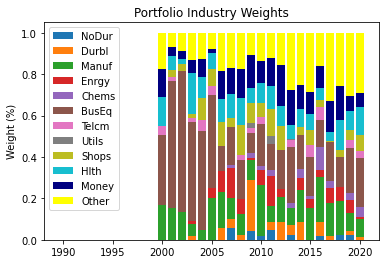

In [43]:
# Plot bars in stack manner
plt.bar(x, y1, color='tab:blue')
plt.bar(x, y2, bottom=y1, color='tab:orange')
plt.bar(x, y3, bottom=tuple(map(sum,zip(y1, y2))), color='tab:green')
plt.bar(x, y4, bottom=tuple(map(sum,zip(y1, y2, y3))), color='tab:red')
plt.bar(x, y5, bottom=tuple(map(sum,zip(y1, y2, y3, y4))), color='tab:purple')
plt.bar(x, y6, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5))), color='tab:brown')
plt.bar(x, y7, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6))), color='tab:pink')
plt.bar(x, y8, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7))), color='tab:gray')
plt.bar(x, y9, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8))), color='tab:olive')
plt.bar(x, y10, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8, y9))), color='tab:cyan')
plt.bar(x, y11, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))), color='navy')
plt.bar(x, y12, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11))), color='yellow')

plt.legend(["NoDur", "Durbl", "Manuf", "Enrgy", "Chems", "BusEq", "Telcm", "Utils", "Shops", "Hlth", "Money", "Other"])
plt.ylabel('Weight (%)')
plt.title('Portfolio Industry Weights')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.show()

### Export Data

In [44]:
indCodes.to_csv('ew_indCodes.csv')

In [45]:
returns3[returns3['year']==2008]['wret'].sum()

-0.4690112897745737

In [46]:
port[port['jdate']=='2020-12-31']['ewret'].sum()

0.3408498492703357

In [47]:
port20 = returns7[returns7['year']==2020]

In [48]:
# port20 = port20.drop(columns=['permco','shrcd','exchcd','ret','retx','retadj','retxadj','month','year','1+retadj'])

In [49]:
# industry['permno'] = industry['permno'].astype(int)

In [50]:
# port20 = pd.merge(port20,industry,how='left',on=['permno'])

In [51]:
port20 = port20[(port20['jdate']>=port20['sicdate'])&(port20['jdate']<=port20['enddate'])]

In [52]:
port20 = port20.drop(columns=['siccd','sicdate','enddate','indCode']).drop_duplicates()

In [53]:
port20.sort_values('volRank')

,permno,permco,namedt,nameendt,jdate,me,month,year,beta,lagbeta,...,annRet,annRet10,volRank,wret,comnam,industry,indDesc,wt_delta,tot_delta,ew_wt
1037,83111,14394,2011-02-10,2021-07-20,2020-12-31,3.434905e+07,12,2020,0.726154,1.468218,...,0.444651,0.410862,1.0,0.008893,ALEXION PHARMACEUTICALS INC,Hlth,"Healthcare, Medical Equipment, and Drugs",0.028893,1.346316,0.021461
1011,14596,54820,2014-04-04,2021-03-28,2020-12-31,1.159411e+07,12,2020,0.695435,1.468458,...,1.659333,1.449254,2.0,0.033187,FIVE 9 INC,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",0.053187,1.346316,0.039505
1026,45728,7029,2006-06-30,2021-09-30,2020-12-31,3.079874e+05,12,2020,1.361580,1.468674,...,-0.004450,0.014449,3.0,-0.000089,INVACARE CORP,Hlth,"Healthcare, Medical Equipment, and Drugs",0.019911,1.346316,0.014789
1013,15071,55113,2019-09-17,2021-09-30,2020-12-31,7.081091e+06,12,2020,1.297010,1.469142,...,0.145521,0.136446,4.0,0.002910,SYNEOS HEALTH INC,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",0.022910,1.346316,0.017017
1021,17906,56427,2018-06-15,2021-09-30,2020-12-31,2.928259e+05,12,2020,1.683615,1.470101,...,-0.275650,-0.208396,5.0,-0.005513,VERRICA PHARMACEUTICALS INC,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",0.014487,1.346316,0.010760
1030,77157,22462,2019-12-27,2021-09-30,2020-12-31,1.870275e+06,12,2020,1.358608,1.470797,...,0.001856,-0.102018,6.0,0.000037,O I GLASS INC,Manuf,"Manufacturing -- Machinery, Trucks, Planes, Of...",0.020037,1.346316,0.014883
1003,11581,323,2020-01-29,2021-09-30,2020-12-31,1.352666e+06,12,2020,1.143430,1.471627,...,-0.129493,-0.105083,7.0,-0.002590,ENERPAC TOOL GROUP CORP,Manuf,"Manufacturing -- Machinery, Trucks, Planes, Of...",0.017410,1.346316,0.012932
1012,14641,54851,2019-08-05,2021-09-30,2020-12-31,1.669881e+07,12,2020,1.075253,1.473610,...,0.867682,0.763437,8.0,0.017354,ZENDESK INC,BusEq,"Business Equipment -- Computers, Software, and...",0.037354,1.346316,0.027745
1020,17899,56421,2018-06-28,2021-09-13,2020-12-31,1.382803e+06,12,2020,0.423804,1.473774,...,1.264108,1.258557,9.0,0.025282,TRANSLATE BIO INC,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",0.045282,1.346316,0.033634
1005,12641,53705,2014-01-09,2021-09-30,2020-12-31,5.054063e+06,12,2020,1.529928,1.474086,...,-0.043432,-0.039998,10.0,-0.000869,AIR LEASE CORP,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",0.019131,1.346316,0.014210


### Export

In [54]:
port20.to_csv('ew_port20.csv')